## Barren Plateaus (BP)

In this notebook, we will explore how to use smart intialization strageties to enhance trainability of VQE, especially for the well-known Barren Plateaus issue.

### Generate Hamiltonians

In [1]:
from generate_hamiltonian import generate_projection_ham
import warnings
warnings.filterwarnings('ignore')

H_4q_ori, H_4q, H_4q_local, _ = generate_projection_ham(4, 4, 1, 10)
H_6q_ori, H_6q, H_6q_local, _ = generate_projection_ham(8, 6, 0.2, 50)
H_8q_ori, H_8q, H_8q_local, _ = generate_projection_ham(16, 8, 0.08, 125)
H_10q_ori, H_10q, H_10q_local, _ = generate_projection_ham(32, 10, 0.01, 1000)

### Visualize the optimization landscape

In [2]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector

# Generate x,y points
X = np.linspace(-1 * np.pi, 1 * np.pi, 100)
Y = np.linspace(-1 * np.pi, 1 * np.pi, 100)

# Generate 2d mesh
xx, yy = np.meshgrid(X, Y)

# VQE loss function
def cost_np(para, ham, circ, ip):
    ip[0] = para[0]
    ip[1] = para[1]
    opt_circ = circ.assign_parameters(ip)
    state = Statevector(opt_circ).data.real
    val = state.T@ham@state
    return val
    
circ4 = RealAmplitudes(4, entanglement="linear", reps=4, skip_final_rotation_layer=False)
circ6 = RealAmplitudes(6, entanglement="linear", reps=6, skip_final_rotation_layer=False)
circ8 = RealAmplitudes(8, entanglement="linear", reps=8, skip_final_rotation_layer=False)
circ10 = RealAmplitudes(10, entanglement="linear", reps=10, skip_final_rotation_layer=False)
seed = 6
rng = np.random.default_rng(seed)
ub = 1*np.pi
lb = -1*np.pi
ip4 = rng.uniform(lb, ub, circ4.num_parameters)
ip6 = rng.uniform(lb, ub, circ6.num_parameters)
ip8 = rng.uniform(lb, ub, circ8.num_parameters)
ip10 = rng.uniform(lb, ub, circ10.num_parameters)

# mid_idx = int(len(ip6)/2)
# print(mid_idx)

# Begin sampling
Z4 = np.array([[cost_np([x, y], H_4q, circ4, ip4) for x in X] for y in Y]).reshape(len(Y), len(X))
Z6 = np.array([[cost_np([x, y], H_6q, circ6, ip6) for x in X] for y in Y]).reshape(len(Y), len(X))
Z8 = np.array([[cost_np([x, y], H_8q, circ8, ip8) for x in X] for y in Y]).reshape(len(Y), len(X))
Z10 = np.array([[cost_np([x, y], H_10q, circ10, ip10) for x in X] for y in Y]).reshape(len(Y), len(X))

CPU times: user 5min 24s, sys: 11min 38s, total: 17min 3s
Wall time: 3min 1s


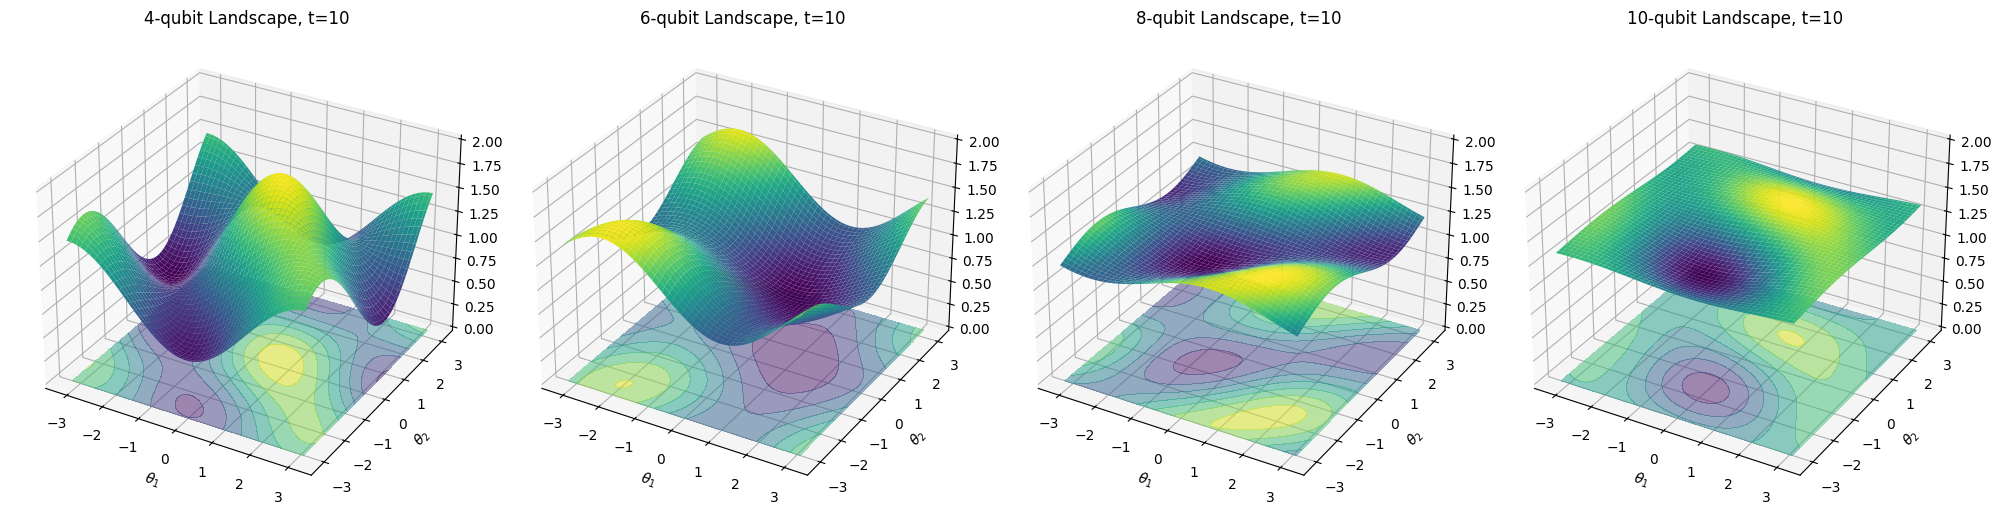

In [18]:
cmap_str = "viridis"
ax_lim = [0.0, 2]

fig = plt.figure(figsize=[20,10])
# ============= first plot =============
# fig = plt.figure(figsize=plt.figaspect(0.3))
ax1 = fig.add_subplot(2, 4, 1, projection='3d')
surf1 = ax1.plot_surface(xx, yy, Z4, cmap=cmap_str)
ax1.contourf(xx, yy, Z4, zdir='z', offset=0.0, cmap=cmap_str, alpha=0.5)
ax1.set_xlabel(r"$\theta_{1}$")
ax1.set_ylabel(r"$\theta_{2}$")
ax1.set_zlim(ax_lim)
ax1.set_title("4-qubit Landscape, t=10")


# ============= second plot =============
ax2 = fig.add_subplot(2, 4, 2, projection='3d')
surf2 = ax2.plot_surface(xx, yy, Z6, cmap=cmap_str)
ax2.contourf(xx, yy, Z6, zdir='z', offset=0.0, cmap=cmap_str, alpha=0.5)
ax2.set_xlabel(r"$\theta_{1}$")
ax2.set_ylabel(r"$\theta_{2}$")
ax2.set_zlim(ax_lim)
ax2.set_title("6-qubit Landscape, t=10")

# ============= third plot =============
ax3 = fig.add_subplot(2, 4, 3, projection='3d')
surf3 = ax3.plot_surface(xx, yy, Z8, cmap=cmap_str)
ax3.contourf(xx, yy, Z8, zdir='z', offset=0.0, cmap=cmap_str, alpha=0.5)
ax3.set_xlabel(r"$\theta_{1}$")
ax3.set_ylabel(r"$\theta_{2}$")
ax3.set_zlim(ax_lim)
ax3.set_title("8-qubit Landscape, t=10")

# ============= forth plot =============
ax4 = fig.add_subplot(2, 4, 4, projection='3d')
surf4 = ax4.plot_surface(xx, yy, Z10, cmap=cmap_str)
ax4.contourf(xx, yy, Z10, zdir='z', offset=0.0, cmap=cmap_str, alpha=0.5)
ax4.set_xlabel(r"$\theta_{1}$")
ax4.set_ylabel(r"$\theta_{2}$")
ax4.set_zlim(ax_lim)
ax4.set_title("10-qubit Landscape, t=10")

# plt.show()
plt.tight_layout()
# plt.colorbar(surf1)
plt.savefig('landscape-bp-theta01.pdf', dpi=300)

## Small-angle initialization

In [19]:
%%time

# generate x,y points
X = np.linspace(-1 * np.pi, 1 * np.pi, 100)
Y = np.linspace(-1 * np.pi, 1 * np.pi, 100)

# generate 2d mesh
xx, yy = np.meshgrid(X, Y)

circ4 = RealAmplitudes(4, entanglement="linear", reps=4, skip_final_rotation_layer=False)
circ6 = RealAmplitudes(6, entanglement="linear", reps=6, skip_final_rotation_layer=False)
circ8 = RealAmplitudes(8, entanglement="linear", reps=8, skip_final_rotation_layer=False)
circ10 = RealAmplitudes(10, entanglement="linear", reps=10, skip_final_rotation_layer=False)
seed = 6
rng = np.random.default_rng(seed)
ub = 1*np.pi
lb = -1*np.pi

## ===================== Small angle initialization =====================
ip4 = rng.uniform(lb/(4*32), ub/(4*32), circ4.num_parameters)
ip6 = rng.uniform(lb/(6*32), ub/(6*32), circ6.num_parameters)
ip8 = rng.uniform(lb/(8*32), ub/(8*32), circ8.num_parameters)
ip10 = rng.uniform(lb/(10*32), ub/(10*32), circ10.num_parameters)

# VQE loss function
def cost_np(para, ham, circ, ip):
    mid_idx = int(len(ip)/2)
    ip[mid_idx] = para[0]
    ip[mid_idx+1] = para[1]
    opt_circ = circ.assign_parameters(ip)
    state = Statevector(opt_circ).data.real
    val = state.T@ham@state
    return val

Z4 = np.array([[cost_np([x, y], H_4q, circ4, ip4) for x in X] for y in Y]).reshape(len(Y), len(X))
Z6 = np.array([[cost_np([x, y], H_6q, circ6, ip6) for x in X] for y in Y]).reshape(len(Y), len(X))
Z8 = np.array([[cost_np([x, y], H_8q, circ8, ip8) for x in X] for y in Y]).reshape(len(Y), len(X))
Z10 = np.array([[cost_np([x, y], H_10q, circ10, ip10) for x in X] for y in Y]).reshape(len(Y), len(X))

CPU times: user 5min 35s, sys: 11min 43s, total: 17min 18s
Wall time: 3min 4s


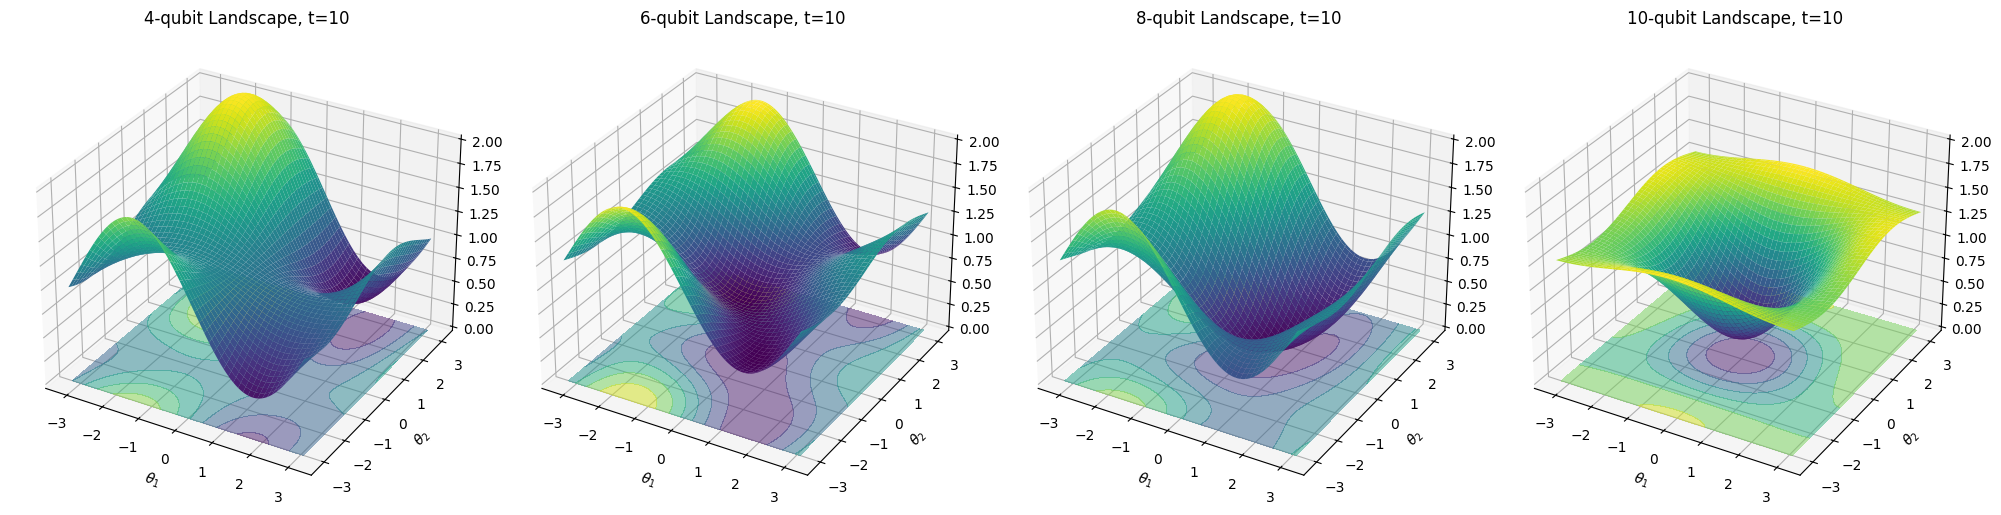

In [20]:
cmap_str = "viridis"
ax_lim = [0.0, 2]

fig = plt.figure(figsize=[20,10])
# ============= first plot =============
# fig = plt.figure(figsize=plt.figaspect(0.3))
ax1 = fig.add_subplot(2, 4, 1, projection='3d')
surf1 = ax1.plot_surface(xx, yy, Z4, cmap=cmap_str)
ax1.contourf(xx, yy, Z4, zdir='z', offset=0.0, cmap=cmap_str, alpha=0.5)
ax1.set_xlabel(r"$\theta_{1}$")
ax1.set_ylabel(r"$\theta_{2}$")
ax1.set_zlim(ax_lim)
ax1.set_title("4-qubit Landscape, t=10")


# ============= second plot =============
ax2 = fig.add_subplot(2, 4, 2, projection='3d')
surf2 = ax2.plot_surface(xx, yy, Z6, cmap=cmap_str)
ax2.contourf(xx, yy, Z6, zdir='z', offset=0.0, cmap=cmap_str, alpha=0.5)
ax2.set_xlabel(r"$\theta_{1}$")
ax2.set_ylabel(r"$\theta_{2}$")
ax2.set_zlim(ax_lim)
ax2.set_title("6-qubit Landscape, t=10")

# ============= third plot =============
ax3 = fig.add_subplot(2, 4, 3, projection='3d')
surf3 = ax3.plot_surface(xx, yy, Z8, cmap=cmap_str)
ax3.contourf(xx, yy, Z8, zdir='z', offset=0.0, cmap=cmap_str, alpha=0.5)
ax3.set_xlabel(r"$\theta_{1}$")
ax3.set_ylabel(r"$\theta_{2}$")
ax3.set_zlim(ax_lim)
ax3.set_title("8-qubit Landscape, t=10")

# ============= forth plot =============
ax4 = fig.add_subplot(2, 4, 4, projection='3d')
surf4 = ax4.plot_surface(xx, yy, Z10, cmap=cmap_str)
ax4.contourf(xx, yy, Z10, zdir='z', offset=0.0, cmap=cmap_str, alpha=0.5)
ax4.set_xlabel(r"$\theta_{1}$")
ax4.set_ylabel(r"$\theta_{2}$")
ax4.set_zlim(ax_lim)
ax4.set_title("10-qubit Landscape, t=10")

# plt.show()
plt.tight_layout()
plt.savefig('landscape-nobp-theta01.pdf', dpi=300)

## Sample gradient

In this section, we will sample gradients and verfity the phenonmenon of barren plateaus using PennyLane.

In [53]:
from pennylane import numpy as np
import pennylane as qml

blue_string1 = '#112C65'
blue_string2 = '#2D5FA3'
blue_string3 = '#5991C2'
blue_string4 = '#90BBD8'
blue_string5 = '#C9D9ED'

# Set a seed for reproducibility
np.random.seed(6)

def RAA(params, D, H_test, num_qubits):
    """The real-amplitude variational quantum circuit.

    Args:
        params (array[float]): array of parameters
        random_gate_sequence (dict): a dictionary of random gates
        num_qubits (int): the number of qubits in the circuit

    Returns:
        float: the expectation value of the target observable
    """
    depth = D
    N = num_qubits
    for i in range(N):
        qml.RY(params[i], wires=i)
    for reps in range(1, depth+1):
        for i in range(N-1):
            qml.CNOT(wires=[i, i+1])
        for i in range(N):
            qml.RY(params[i+N*reps], wires=i)  
            
    wirelist = [i for i in range(num_qubits)]
    return qml.expval(qml.Hermitian(H_test, wirelist))


def RAAcor(params, D, H_test, num_qubits):
    depth = D
    N = num_qubits
    for i in range(N):
        qml.RY(params[0], wires=i)
    for reps in range(1, depth+1):
        for i in range(N-1):
            qml.CNOT(wires=[i, i+1])
        for i in range(N):
            qml.RY(params[reps], wires=i)  

    wirelist = [i for i in range(num_qubits)]
    return qml.expval(qml.Hermitian(H_test, wirelist))

### Without any special treatment

In [70]:
num_qubits = 4
num_samples = 100
dev = qml.device("default.qubit", wires=num_qubits)

var_Dlist_4q_avg = []
mean_Dlist_4q_avg = []
for D in range(0,11,1):
    grad_vals = []
    for i in range(num_samples):
        qcircuit = qml.QNode(RAA, dev, interface="autograd")
        grad = qml.grad(qcircuit, argnum=0)
        params = np.random.uniform(0*np.pi, 2*np.pi, num_qubits*(D+1))
        gradient = grad(params, D, H_4q, num_qubits)
        grad_vals.append(gradient[0]) 
    var_Dlist_4q_avg.append(np.var(grad_vals))
    mean_Dlist_4q_avg.append(np.mean(grad_vals))

In [71]:
num_qubits = 6
num_samples = 100
dev = qml.device("default.qubit", wires=num_qubits)

var_Dlist_6q_avg = []
mean_Dlist_6q_avg = []
for D in range(0,11,1):
    grad_vals = []
    for i in range(num_samples):
        qcircuit = qml.QNode(RAA, dev, interface="autograd")
        grad = qml.grad(qcircuit, argnum=0)
        params = np.random.uniform(0*np.pi, 2*np.pi, num_qubits*(D+1))
        gradient = grad(params, D, H_6q, num_qubits)
        grad_vals.append(gradient[0])
    var_Dlist_6q_avg.append(np.var(grad_vals))
    mean_Dlist_6q_avg.append(np.mean(grad_vals))

In [72]:
num_qubits = 8
num_samples = 100
dev = qml.device("default.qubit", wires=num_qubits)

var_Dlist_8q_avg = []
mean_Dlist_8q_avg = []
for D in range(0,11,1):
    grad_vals = []
    for i in range(num_samples):
        qcircuit = qml.QNode(RAA, dev, interface="autograd")
        grad = qml.grad(qcircuit, argnum=0)
        params = np.random.uniform(0*np.pi, 2*np.pi, num_qubits*(D+1))
        gradient = grad(params, D, H_8q, num_qubits)
        grad_vals.append(gradient[0])
    var_Dlist_8q_avg.append(np.var(grad_vals))
    mean_Dlist_8q_avg.append(np.mean(grad_vals))

In [73]:
num_qubits = 10
num_samples = 100
dev = qml.device("default.qubit", wires=num_qubits)

var_Dlist_10q_avg = []
mean_Dlist_10q_avg = []
for D in range(0,11,1):
    grad_vals = []
    for i in range(num_samples):
        qcircuit = qml.QNode(RAA, dev, interface="autograd")
        grad = qml.grad(qcircuit, argnum=0)
        params = np.random.uniform(0*np.pi, 2*np.pi, num_qubits*(D+1))
        gradient = grad(params, D, H_10q, num_qubits)
        grad_vals.append(gradient[0])
    var_Dlist_10q_avg.append(np.var(grad_vals))
    mean_Dlist_10q_avg.append(np.mean(grad_vals))

### Small Angle (SA) initialization + Parameter correlation

In [65]:
num_qubits = 4
num_samples = 100
dev = qml.device("default.qubit", wires=num_qubits)

var_Dlist_4q_cor = []
mean_Dlist_4q_cor = []
for D in range(0,11,1):
    grad_vals = []
    for i in range(num_samples):
        qcircuit = qml.QNode(RAAcor, dev, interface="autograd")
        grad = qml.grad(qcircuit, argnum=0)
        params = np.random.uniform(0*np.pi/num_qubits, 2*np.pi/num_qubits, D+1)
        gradient = grad(params, D, H_4q, num_qubits)
        grad_vals.append(gradient[0]) 
    var_Dlist_4q_cor.append(np.var(grad_vals))
    mean_Dlist_4q_cor.append(np.mean(grad_vals))

In [66]:
num_qubits = 6
num_samples = 100
dev = qml.device("default.qubit", wires=num_qubits)

var_Dlist_6q_cor = []
mean_Dlist_6q_cor = []
for D in range(0,11,1):
    grad_vals = []
    for i in range(num_samples):
        qcircuit = qml.QNode(RAAcor, dev, interface="autograd")
        grad = qml.grad(qcircuit, argnum=0)
        params = np.random.uniform(0*np.pi/num_qubits, 2*np.pi/num_qubits, D+1)
        gradient = grad(params, D, H_6q, num_qubits)
        grad_vals.append(gradient[0])
    var_Dlist_6q_cor.append(np.var(grad_vals))
    mean_Dlist_6q_cor.append(np.mean(grad_vals))

In [67]:
num_qubits = 8
num_samples = 100
dev = qml.device("default.qubit", wires=num_qubits)

var_Dlist_8q_cor = []
mean_Dlist_8q_cor = []
for D in range(0,11,1):
    grad_vals = []
    for i in range(num_samples):
        qcircuit = qml.QNode(RAAcor, dev, interface="autograd")
        grad = qml.grad(qcircuit, argnum=0)
        params = np.random.uniform(0*np.pi/num_qubits, 2*np.pi/num_qubits, D+1)
        gradient = grad(params, D, H_8q, num_qubits)
        grad_vals.append(gradient[0])
    var_Dlist_8q_cor.append(np.var(grad_vals))
    mean_Dlist_8q_cor.append(np.mean(grad_vals))

In [68]:
num_qubits = 10
num_samples = 100
dev = qml.device("default.qubit", wires=num_qubits)

var_Dlist_10q_cor = []
mean_Dlist_10q_cor = []
for D in range(0,11,1):
    grad_vals = []
    for i in range(num_samples):
        qcircuit = qml.QNode(RAAcor, dev, interface="autograd")
        grad = qml.grad(qcircuit, argnum=0)
        params = np.random.uniform(0*np.pi/num_qubits, 2*np.pi/num_qubits, D+1)
        gradient = grad(params, D, H_10q, num_qubits)
        grad_vals.append(gradient[0])
    var_Dlist_10q_cor.append(np.var(grad_vals))
    mean_Dlist_10q_cor.append(np.mean(grad_vals))

**Notice: The sampling process might take about 10 minutes.** Or one can import precomputed data.

In [75]:
import pandas as pd

df = pd.read_csv('var_nobp_qubitcorrelate.csv')
var_Dlist_4q_cor = df['4-qubit'].to_numpy()
var_Dlist_6q_cor = df['6-qubit'].to_numpy()
var_Dlist_8q_cor = df['8-qubit'].to_numpy()
var_Dlist_10q_cor = df['10-qubit'].to_numpy()

In [78]:
import pandas as pd

df = pd.read_csv('var_bp_avgs200_d10.csv')
var_Dlist_4q_avg = df['4-qubit'].to_numpy()
var_Dlist_6q_avg = df['6-qubit'].to_numpy()
var_Dlist_8q_avg = df['8-qubit'].to_numpy()
var_Dlist_10q_avg = df['10-qubit'].to_numpy()

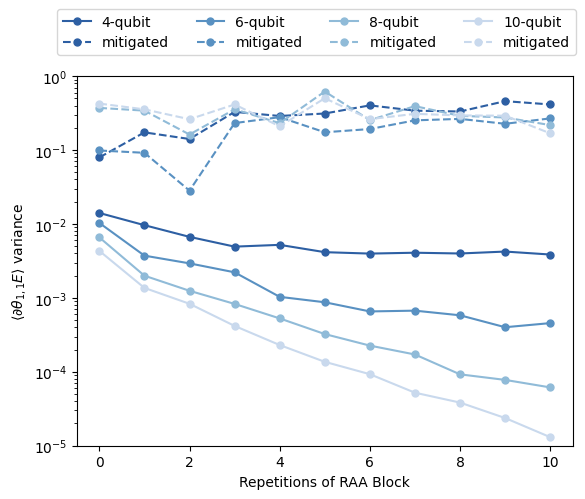

In [79]:
# 4-qubit
plt.semilogy(var_Dlist_4q_avg, 'o-', markersize=5, alpha=1, color=blue_string2, label="4-qubit", markerfacecolor=blue_string2, markeredgecolor=blue_string2)
plt.semilogy(var_Dlist_4q_cor, 'o--', markersize=5, alpha=1, color=blue_string2, label="mitigated", markerfacecolor=blue_string2, markeredgecolor=blue_string2)

# 6-qubit
plt.semilogy(var_Dlist_6q_avg, 'o-', markersize=5, alpha=1, color=blue_string3, label="6-qubit", markerfacecolor=blue_string3, markeredgecolor=blue_string3)
plt.semilogy(var_Dlist_6q_cor, 'o--', markersize=5, alpha=1, color=blue_string3, label="mitigated", markerfacecolor=blue_string3, markeredgecolor=blue_string3)

# 8-qubit
plt.semilogy(var_Dlist_8q_avg, 'o-', markersize=5, alpha=1, color=blue_string4, label="8-qubit", markerfacecolor=blue_string4, markeredgecolor=blue_string4)
plt.semilogy(var_Dlist_8q_cor, 'o--', markersize=5, alpha=1, color=blue_string4, label="mitigated", markerfacecolor=blue_string4, markeredgecolor=blue_string4)

# 10-qubit
plt.semilogy(var_Dlist_10q_avg, 'o-',markersize=5, alpha=1, color=blue_string5, label="10-qubit", markerfacecolor=blue_string5, markeredgecolor=blue_string5)
plt.semilogy(var_Dlist_10q_cor, 'o--',markersize=5, alpha=1, color=blue_string5, label="mitigated", markerfacecolor=blue_string5, markeredgecolor=blue_string5)

plt.ylim([1e-5, 10*1e-1])
plt.xlabel(r"Repetitions of RAA Block")
plt.ylabel(r"$\langle \partial \theta_{1, 1} E\rangle$ variance")
plt.legend(bbox_to_anchor=(1.02, 1.2), ncol=4)
# plt.savefig("var-nobp-SA-qubitcorrelate.pdf", dpi=300)

## Software info

In [80]:
import qiskit
import qiskit_ibm_runtime
import pennylane as qml

print(f'Qiskit: {qiskit.__version__}')
print(f'Qiskit IBM Runtime: {qiskit_ibm_runtime.__version__}')
print(f'PennyLane: {qml.__version__}')

Qiskit: 1.0.2
Qiskit IBM Runtime: 0.23.0
PennyLane: 0.35.1
